# Location and Attendance Analysis

In [ ]:
import sys
from pathlib import Path

base_dir = Path.cwd().parent
sys.path.insert(0, str(base_dir))

import os
import pickle as pkl
import numpy as np
import pandas as pd
import utils

### EDIT PATHS ###
base_dir = Path.cwd().parent
image_dir = "/path/to/preprocessed_images"
attendance_path = "/path/to/attendance.xlsx"  #(not public)

# Repo-relative paths (do not change)
cache_dir = base_dir / "outputs" / "cache"
labels_path = base_dir / "data" / "cluster_labels.xlsx"
metadata_path = base_dir / "data" / "image_preprocessing_labels.xlsx"
hdbscan_path = "hdbscan_l2norm_90pca_6components_100nn_0dist_cosine_42randseed_100_minclustsize_22minsamples.pkl"

filenames = os.listdir(image_dir)

with open(cache_dir / hdbscan_path, "rb") as file:
    hdbscan_model = pkl.load(file)

hdbscan_model.labels_ = utils.relabel_by_size(hdbscan_model.labels_)

## Location Frequencies

In [24]:
metadata_labeled_df = pd.read_excel(metadata_path, sheet_name="Sheet1")
metadata_labeled_df["is_inlier"] = metadata_labeled_df["filename"].isin(filenames)

print("METADATA: ", metadata_labeled_df["is_inlier"].value_counts())

# NO METADATA FOR 67 IMAGES

location_frequencies = metadata_labeled_df[metadata_labeled_df["is_inlier"] == True]["location"].value_counts()
location_frequencies_percentage = location_frequencies / location_frequencies.sum() * 100
print("Location Frequencies:\n", location_frequencies)
print("Location Frequencies (Percentage):\n", location_frequencies_percentage)

metadata_labeled_df.fillna({"location": "Unknown"}, inplace=True)
print(metadata_labeled_df["location"].value_counts())

METADATA:  is_inlier
True     9700
False     898
Name: count, dtype: int64
Location Frequencies:
 location
London       3434
Edinburgh    3023
Belfast      2481
Cardiff       695
Name: count, dtype: int64
Location Frequencies (Percentage):
 location
London       35.648292
Edinburgh    31.381709
Belfast      25.755216
Cardiff       7.214783
Name: count, dtype: float64
location
London       3789
Edinburgh    3198
Belfast      2639
Cardiff       862
Unknown       110
Name: count, dtype: int64


## Assign Clusters to Metadata

In [25]:
new_labels = utils.relabel_by_size(hdbscan_model.labels_)

for filename, label in zip(filenames, new_labels):
    label = int(label)
    metadata_labeled_df.loc[metadata_labeled_df["filename"] == filename, "cluster"] = label
    if filename not in metadata_labeled_df["filename"].values:
        metadata_labeled_df = pd.concat(
            [metadata_labeled_df, pd.DataFrame({"filename": [filename], "cluster": [label]})],
            ignore_index=True,
        )

metadata_labeled_df["cluster"] = metadata_labeled_df["cluster"].astype("Int64")

display(metadata_labeled_df)
print(metadata_labeled_df["cluster"].value_counts(sort=False))
print(metadata_labeled_df["cluster"].count())

,filename,written_form,keep_duplicate,label,corrupted,location,is_inlier,cluster
0,29c0decb-868e-47cc-8529-2097d2b01d40.jpg,False,1.0,1.0,False,London,True,6
1,a0ca23f5-3aff-40f1-be18-0d905839d074.jpg,False,0.0,1.0,False,London,False,<NA>
2,a84402fe-4408-4497-bf29-2e2968037a09.jpg,False,0.0,1.0,False,London,False,<NA>
3,c7f60a4b-fb36-41b7-8584-678486519354.jpg,False,1.0,2.0,False,London,True,2
4,122f4760-e808-40b3-8f00-46f4ed476042.jpg,False,0.0,2.0,False,London,False,<NA>
...,...,...,...,...,...,...,...,...
10593,5c7114c4-5b25-4219-9d53-84b0775d71fd.jpg,False,NaN,NaN,False,Unknown,True,5
10594,bccdcaf3-3c68-4251-b679-1c7cec883920.jpg,False,NaN,NaN,False,Unknown,True,9
10595,7105730a-d44c-4d6d-9ff5-31640b71ff92.jpg,False,NaN,NaN,False,Unknown,True,-1
10596,32dbaf9e-cbb3-4761-9fc3-a733477cf340.jpg,False,NaN,NaN,False,Unknown,True,-1


cluster
6      279
2      821
-1    3964
4      645
1     1377
10     162
7      267
15     133
12     145
3      702
5      352
8      236
9      175
13     144
11     154
14     144
Name: count, dtype: Int64
9700


## Chi-Squared Tests


### Not including unknown location

In [26]:
from scipy.stats import chi2_contingency

# Create a contingency table of cluster vs location
filtered_df = metadata_labeled_df[metadata_labeled_df["cluster"].notna()]
contingency = pd.crosstab(filtered_df["cluster"], filtered_df["location"], dropna=False)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-squared: {chi2}, p-value: {p}, Degrees of freedom: {dof}")

# Create a contingency with totals
contingency_totals = pd.crosstab(filtered_df["cluster"], filtered_df["location"], dropna=False)
contingency_totals["Sum"] = contingency.sum(axis=1)
contingency_totals.loc["Sum"] = contingency.sum(axis=0)
print("\nContingency Table with Totals:")
display(contingency_totals)

# Create a contingency table normalized by rows (percentage values)
percentage_contingency = pd.crosstab(filtered_df["cluster"], filtered_df["location"], dropna=False, normalize="index") * 100
percentage_contingency = percentage_contingency.round(2)

overall_total = metadata_labeled_df["cluster"].count()
row_pct = ((contingency.sum(axis=1) / overall_total) * 100).round(2)
col_pct = ((contingency.sum(axis=0) / overall_total) * 100).round(2)
percentage_contingency["RowTotal"] = row_pct
col_pct["Sum"] = 100.0
percentage_contingency.loc["Sum"] = col_pct

print("\nPercentage Contingency Table with Totals:")
display(percentage_contingency)

Chi-squared: 192.37235567954048, p-value: 8.785445233878136e-16, Degrees of freedom: 60

Contingency Table with Totals:


location,Belfast,Cardiff,Edinburgh,London,Unknown,Sum
cluster,,,,,,
-1,958.0,281.0,1205.0,1488.0,32.0,3964.0
1,348.0,104.0,478.0,443.0,4.0,1377.0
2,217.0,46.0,220.0,335.0,3.0,821.0
3,169.0,51.0,235.0,243.0,4.0,702.0
4,243.0,33.0,215.0,149.0,5.0,645.0
5,100.0,30.0,97.0,114.0,11.0,352.0
6,58.0,26.0,86.0,109.0,0.0,279.0
7,82.0,23.0,83.0,78.0,1.0,267.0
8,53.0,18.0,62.0,103.0,0.0,236.0



Percentage Contingency Table with Totals:


location,Belfast,Cardiff,Edinburgh,London,Unknown,RowTotal
cluster,,,,,,
-1,24.17,7.09,30.40,37.54,0.81,40.87
1,25.27,7.55,34.71,32.17,0.29,14.20
2,26.43,5.60,26.80,40.80,0.37,8.46
3,24.07,7.26,33.48,34.62,0.57,7.24
4,37.67,5.12,33.33,23.10,0.78,6.65
5,28.41,8.52,27.56,32.39,3.12,3.63
6,20.79,9.32,30.82,39.07,0.00,2.88
7,30.71,8.61,31.09,29.21,0.37,2.75
8,22.46,7.63,26.27,43.64,0.00,2.43


### Including Uknown Location

In [27]:
from scipy.stats import chi2_contingency

# Create a contingency table of cluster vs location
contingency = pd.crosstab(metadata_labeled_df['cluster'], metadata_labeled_df['location'])

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-squared: {chi2}, p-value: {p}, Degrees of freedom: {dof}")


# Create a contingency with totals
contingency_totals = pd.crosstab(metadata_labeled_df['cluster'], metadata_labeled_df['location'])
contingency_totals['Sum'] = contingency.sum(axis=1)
contingency_totals.loc['Sum'] = contingency.sum(axis=0)
print("\nContingency Table with Totals:")
display(contingency_totals)

# Create a contingency table normalized by rows (percentage values)
percentage_contingency = pd.crosstab(metadata_labeled_df['cluster'], metadata_labeled_df['location'], normalize='index') * 100
percentage_contingency = percentage_contingency.round(2)

overall_total = metadata_labeled_df['cluster'].count()
row_pct = ((contingency.sum(axis=1) / overall_total) * 100).round(2)
col_pct = ((contingency.sum(axis=0) / overall_total) * 100).round(2)
percentage_contingency['RowTotal'] = row_pct
col_pct['Sum'] = 100.0
percentage_contingency.loc['Sum'] = col_pct

print("\nPercentage Contingency Table with Totals:")
display(percentage_contingency)

Chi-squared: 192.37235567954048, p-value: 8.785445233878136e-16, Degrees of freedom: 60

Contingency Table with Totals:


location,Belfast,Cardiff,Edinburgh,London,Unknown,Sum
cluster,,,,,,
-1,958.0,281.0,1205.0,1488.0,32.0,3964.0
1,348.0,104.0,478.0,443.0,4.0,1377.0
2,217.0,46.0,220.0,335.0,3.0,821.0
3,169.0,51.0,235.0,243.0,4.0,702.0
4,243.0,33.0,215.0,149.0,5.0,645.0
5,100.0,30.0,97.0,114.0,11.0,352.0
6,58.0,26.0,86.0,109.0,0.0,279.0
7,82.0,23.0,83.0,78.0,1.0,267.0
8,53.0,18.0,62.0,103.0,0.0,236.0



Percentage Contingency Table with Totals:


location,Belfast,Cardiff,Edinburgh,London,Unknown,RowTotal
cluster,,,,,,
-1,24.17,7.09,30.40,37.54,0.81,40.87
1,25.27,7.55,34.71,32.17,0.29,14.20
2,26.43,5.60,26.80,40.80,0.37,8.46
3,24.07,7.26,33.48,34.62,0.57,7.24
4,37.67,5.12,33.33,23.10,0.78,6.65
5,28.41,8.52,27.56,32.39,3.12,3.63
6,20.79,9.32,30.82,39.07,0.00,2.88
7,30.71,8.61,31.09,29.21,0.37,2.75
8,22.46,7.63,26.27,43.64,0.00,2.43


## Adjusted Pearson (Standardized) Residuals

Resource: https://cscu.cornell.edu/wp-content/uploads/conttableresid.pdf

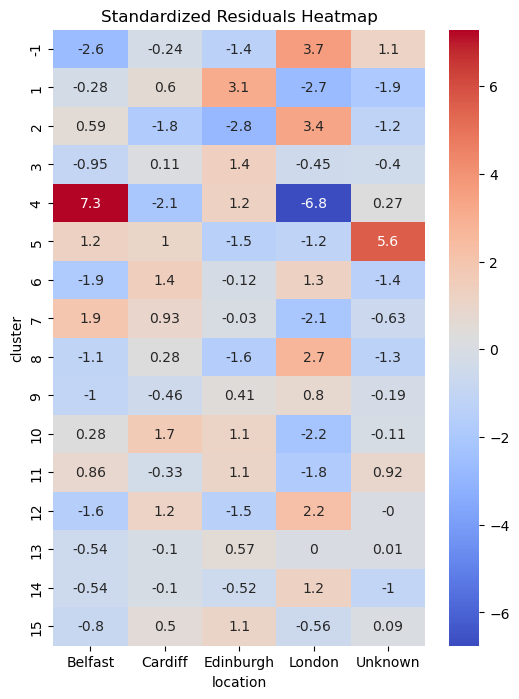

Bonferroni-corrected significance threshold: 0.000625
Critical Chi-squared value for Bonferroni correction: 3.4205267011318305


In [28]:
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

residuals = (contingency - expected) / np.sqrt(
    expected *
    (1 - contingency.sum(axis=1).values[:, None] / contingency.values.sum()) *
    (1 - contingency.sum(axis=0).values[None, :] / contingency.values.sum())
)

plt.figure(figsize=(6, 8))
sns.heatmap(residuals.round(2), annot=True, cmap="coolwarm")
plt.title("Standardized Residuals Heatmap")
plt.show()

bonferrioni_threshold = 0.05 / (contingency.shape[0] * contingency.shape[1])
critical_value = norm.ppf(1 - bonferrioni_threshold/2)
print(f"Bonferroni-corrected significance threshold: {bonferrioni_threshold}")
print(f"Critical Chi-squared value for Bonferroni correction: {critical_value}")

## Effect Size (Cramer's V)

In [29]:
n = contingency.values.sum()
cramer_v = np.sqrt(chi2 / (n * (min(contingency.shape)-1)))
print("Cramer's V:", cramer_v)

Cramer's V: 0.07041342488554202


## Attendance Analysis (Not Public)

### HS & DL Sessions

In [30]:
# Session Attendance Analysis
if attendance_path is None:
    raise FileNotFoundError("Set attendance_path to run this section.")

session_attendance_df = pd.read_excel(attendance_path, sheet_name='Sheet1')

# Session counts and percentages
session_counts = session_attendance_df['session'].value_counts()
print("Session Counts:", session_counts)
print("Total:", session_attendance_df['session'].count())
session_percentage = session_counts / session_counts.sum() * 100
print("Session Percentage:")
print(session_percentage)

# Attendance counts by session type
session_type_counts = session_attendance_df.groupby('session')['scanned'].sum()
print("\nAttendance per Session Counts:", session_type_counts)
print("Total:", session_attendance_df['scanned'].count())
print("Attendance per Session Percentage:")
print(session_type_counts / session_attendance_df['scanned'].sum() * 100)

Session Counts: session
HS    1386
DL     399
Name: count, dtype: int64
Total: 1785
Session Percentage:
session
HS    77.647059
DL    22.352941
Name: count, dtype: float64

Attendance per Session Counts: session
DL     6441
HS    31700
Name: scanned, dtype: int64
Total: 1785
Attendance per Session Percentage:
session
DL    16.887339
HS    83.112661
Name: scanned, dtype: float64


### By Location

In [31]:
# Session counts and percentages
location_counts = session_attendance_df['location'].value_counts()
print("Session Counts:", location_counts)
print("Total:", session_attendance_df['location'].count())
location_percentage = location_counts / location_counts.sum() * 100
print("Session Percentage:")
print(location_percentage)

# Attendance counts by session type
session_type_counts = session_attendance_df.groupby('location')['scanned'].sum()
print("\nAttendance per Session Counts:", session_type_counts)
print("Total:", session_attendance_df['scanned'].count())
print("Attendance per Session Percentage:")
print(session_type_counts / session_attendance_df['scanned'].sum() * 100)

Session Counts: location
London       703
Belfast      383
Edinburgh    377
Cardiff      322
Name: count, dtype: int64
Total: 1785
Session Percentage:
location
London       39.383754
Belfast      21.456583
Edinburgh    21.120448
Cardiff      18.039216
Name: count, dtype: float64

Attendance per Session Counts: location
Belfast       6257
Cardiff       5259
Edinburgh     9248
London       17377
Name: scanned, dtype: int64
Total: 1785
Attendance per Session Percentage:
location
Belfast      16.404919
Cardiff      13.788312
Edinburgh    24.246873
London       45.559896
Name: scanned, dtype: float64
